# CNN autoencoder metrics

In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import numpy as np
import pandas as pd
import torch
import math
from tqdm import tqdm

# Viz
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# custom packages
import src.commons.constants as cons
from src.commons.segmentation_utils import get_scores, get_filled_score_map, plot_input_gt_score_bw_mask

# U-Net custom implementation
from src.models.u_net import *

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# Default size of matplotlib figures
matplotlib.rcParams['figure.figsize'] = [6, 4]

## Load the model

In [2]:
def load_the_category_model(category, resize_dim):
    CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
    CHECKPOINT_PATH = os.path.join(CHECKPOINT_PATH, 'autoencoder_models')
    PATH = os.path.join(CHECKPOINT_PATH, f"autoencoder_{category}_resizedim_{resize_dim}.pt")
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Load the model
    model = SegmentationNetwork(n_channels=3, n_classes=3).to(DEVICE)
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [3]:
#category = 'tile'
#resize_dim = 200
#model = load_the_category_model(category, resize_dim)

## Load the test data

In [4]:
#test_data = load_test_data(category, batch_size=4)
#test_data

## Model predictions

In [5]:
#inputs, recons, targets = predict(model, test_data['test'], resize_dim=resize_dim)

In [6]:
# reorganise the dimensions
#inputs_resh = einops.rearrange(inputs, "n b c h w -> (n b) h w c")
#recons_resh = einops.rearrange(recons, "n b c h w -> (n b) h w c")
#targets_resh = einops.rearrange(targets, "n b c h w -> (n b) h w c")

## Metrics

In [7]:
import src.commons.internal_metrics as i_metrics
import src.commons.external_metrics as e_metrics

In [8]:
def get_pixel_level_metrics(inputs, recons, targets, idx, threshold=0.5):
    scores, _ = get_scores(inputs, recons, idx)
    fpr = i_metrics.get_fpr(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    prc = i_metrics.get_prc(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    iou = i_metrics.get_iou(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    return {'fpr': fpr, 'prc': prc, 'iou': iou}


def get_region_level_metrics(inputs, recons, targets, idx, threshold=0.5):
    scores, _ = get_scores(inputs, recons, idx)
    pro = i_metrics.get_pro(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    return {'pro': pro}


def get_threshold_independent_metrics(inputs, recons, targets, idx, fill_gaps=False):
    scores, _ = get_scores(inputs, recons, idx)
    scores = scores.numpy()
    gt_mask = targets[idx][:,:,0].numpy()
    gt_mask = np.where(gt_mask > 0.5, 1, 0)
    if (gt_mask == 1).any():
        mroc = i_metrics.fpr_pro_iou_curves(y_true=gt_mask, y_score=scores, fill_gaps=fill_gaps)
        return mroc
    else: 
        logging.debug(f"This image {idx} is not anomalous.")
        return {}
    

def get_plot(inputs, recons, targets, idx, threshold=0.5, fill_gaps=False):
    scores, bw_scores = get_scores(inputs, recons, idx, threshold)
    if fill_gaps:
        bw_scores = get_filled_score_map(scores.numpy(), threshold)
    
    fig, axs = plt.subplots(1, 5, figsize=(8, 8))
    axs[0].imshow(inputs[idx])
    axs[0].set_title('Raw image')
    axs[0].axis('off')
    axs[1].imshow(recons[idx])
    axs[1].set_title('Generated image')
    axs[1].axis('off')
    axs[2].imshow(scores, cmap="Greys_r")
    axs[2].set_title('Score map')
    axs[2].axis('off')
    axs[3].imshow(bw_scores, cmap="Greys_r")
    axs[3].set_title('Score map binary')
    axs[3].axis('off')
    axs[4].imshow(targets[idx])
    axs[4].set_title('Target')
    axs[4].axis('off')
    fig.tight_layout()
    plt.show()


def get_auc_data(inputs, recons, targets, idx):
    scores, _ = get_scores(inputs, recons, idx)
    gt_mask = targets[idx][:,:,0].numpy()
    gt_mask = np.where(gt_mask > 0.5, 1, 0)
    if (gt_mask == 1).any():
        img_metrics = e_metrics.compute_pixelwise_retrieval_metrics(
            anomaly_segmentations=scores.numpy(), 
            ground_truth_masks=gt_mask
            )
        return img_metrics
    else: 
        logging.debug(f"This image {idx} is not anomalous.")
        return {}


def plot_pro_curve(mroc_py):
    fig, ax1 = plt.subplots(figsize=(4,4))
    ax2 = ax1.twinx()
    ax1.plot(mroc_py['fpr'], mroc_py['pro'])
    ax1.set_ylabel('PRO')
    ax1.set_xlabel('FPR')
    ax2.plot(mroc_py['fpr'], mroc_py['threshold'], color='gold', alpha=0.5)
    ax2.set_ylabel('Threshold', color='gold')
    plt.title('FPR PRO curve & respective threshold')
    plt.show()
    

In [9]:
#idx = 1
#threshold = 0.5

In [10]:
#pixel_level_results = get_pixel_level_metrics(inputs_resh, recons_resh, targets_resh, idx, threshold=threshold)
#pixel_level_results

In [11]:
#img_metrics = get_auc_data(inputs_resh, recons_resh, targets_resh, idx)
#
#plt.figure(figsize=(4,4))
#plt.plot(img_metrics['fpr'], img_metrics['tpr'])
#plt.title(f"Pixel based AUROC = {img_metrics['auroc']:.4f} \n optimal threshold = {img_metrics['optimal_threshold']:.2f}")
#plt.xlabel('FPR')
#plt.ylabel('TNR')
#plt.show()

In [12]:
#region_level_results = get_region_level_metrics(inputs_resh, recons_resh, targets_resh, idx, threshold=threshold)
#region_level_results

In [13]:
#%%time
#mroc_py = get_threshold_independent_metrics(inputs_resh, recons_resh, targets_resh, idx)

In [14]:
#get_plot(inputs_resh, recons_resh, targets_resh, idx, threshold=threshold)

## Calculate for all images in same category

In [15]:
def get_pixel_based_and_region_based_metrics_for_all_test_images(inputs_resh, recons_resh, targets_resh):
    pixel_based, region_based = [], []
    
    # to select the threshold
    pbar = tqdm(enumerate(inputs_resh), total=len(inputs_resh))
    for idx, batch in pbar:
        # Pixel based | ROC curve
        pixel_based.append(get_auc_data(inputs_resh, recons_resh, targets_resh, idx-1))
        # Region based | PRO curve
        region_based.append(get_threshold_independent_metrics(inputs_resh, recons_resh, targets_resh, idx-1, fill_gaps=False))
    return {'pixel_based': pixel_based, 'region_based': region_based}

In [16]:
#pixel_and_region_results = get_pixel_based_and_region_based_metrics_for_all_test_images(inputs_resh, recons_resh, targets_resh)
#pixel_based = pixel_and_region_results['pixel_based']
#region_based = pixel_and_region_results['region_based']

In [17]:
# select the threshold
#optimal_thresholds = np.array([results['optimal_threshold'] for results in pixel_based if results != {}])
#print(f"Min    optimal threshold: {optimal_thresholds.min():.4f}")
#print(f"Median optimal threshold: {np.median(optimal_thresholds):.4f}")
#print(f"Mean   optimal threshold: {optimal_thresholds.mean():.4f}")
#print(f"Max    optimal threshold: {optimal_thresholds.max():.4f}")

In [18]:
def get_aurocs_of_all_test_images(pixel_based):
    df_thr_indep_results = pd.DataFrame()
    aurocs = []
    pixel_based_clean = [x for x in pixel_based if x != {}]
    for i in range(len(pixel_based_clean)):
        auroc = pixel_based_clean[i]['auroc']
        if torch.is_tensor(auroc):
            aurocs.append(auroc.numpy()*1)
        else:
            aurocs.append(auroc)
    
    df_thr_indep_results['auroc'] = aurocs
    return df_thr_indep_results

In [19]:
#df_thr_indep_results = get_aurocs_of_all_test_images(pixel_based)
#df_thr_indep_results.describe()

In [39]:
def build_pro_fpr_curve_with_all_test_images(category, region_based, resize_dim):
    regions_anomalies = np.array([x for x in region_based if x != {}])
    proaucs = np.array([results['proauc'] for results in region_based if results != {}])
    pros = np.array([x['pro'] for x in region_based if x != {}])
    fprs = np.array([x['fpr'] for x in region_based if x != {}])

    # get median of each position
    len_pros = [len(x) for x in pros]
    median_pros, median_fprs = [], []
    
    for i in range(np.min(len_pros)):
        all_pro_i = np.array([pro[i] for pro in pros])
        all_fpr_i = np.array([fpr[i] for fpr in fprs])
        median_pros.append(np.median(all_pro_i))
        median_fprs.append(np.median(all_fpr_i))
    
    fpr_steps = [x for x in np.arange(0, 0.325, 0.025)]

    bucket_for_fprs = {}
    for fpr in fpr_steps:
        df_pro_in_range = []
        for img_results in regions_anomalies:
            df_img_results = pd.DataFrame({'fpr': img_results['fpr'], 'pro': img_results['pro']})
            df_pro_in_range_tmp = df_img_results[(df_img_results['fpr'] >= fpr) & (df_img_results['fpr'] < (fpr + 0.025))].pro.values
            df_pro_in_range.extend(df_pro_in_range_tmp)
        bucket_for_fprs[f'{fpr}'] = df_pro_in_range

    results_path = ".." + cons.DIR_SEP + os.path.join("results")
    results_path = os.path.join(results_path, 'autoencoder_pro_fpr')
    results_path = os.path.join(results_path, f"autoencoder_{category}_resizedim_{resize_dim}.png")

    plt.rcParams['font.size'] = 10
    
    plt.boxplot([bucket_for_fprs[k] for k in bucket_for_fprs.keys()], positions=[round(float(k), 3) for k in bucket_for_fprs.keys()], widths=([0.01] * len(bucket_for_fprs.keys())), showfliers=False)
    plt.plot(fprs[proaucs.argmin()], pros[proaucs.argmin()], label=f'min AU-PRO: {proaucs.min():.3f}')
    plt.plot(fprs[proaucs.argmax()], pros[proaucs.argmax()], label=f'max AU-PRO: {proaucs.max():.3f}')
    plt.plot([0, 0.3], [0, 1], color='gray', alpha=0.2)
    plt.xlim((-0.0125, 0.3))
    plt.xlabel('FPR')
    plt.ylabel('PRO')
    plt.xticks(rotation=45)
    plt.title(f'PRO FPR curve for "{category}" category with {resize_dim} dim.', fontsize=12)
    plt.legend()
    plt.savefig(results_path)
    plt.show()


In [21]:
#build_pro_fpr_curve_with_all_test_images(category, region_based, resize_dim)

In [22]:
def plot_matrix_of_pro_curves_1_for_each_test_image(results):
    plt.rcParams['font.size'] = 6
    results = [r for r in results if r != {}]
    total_r = len(results)
    total_cols = 5
    total_lines = math.ceil(total_r / total_cols)

    fig, ax1 = plt.subplots(total_lines, total_cols, figsize=(total_cols*3 , total_lines*3))
    for n in range(total_r):
        i = math.floor(n/total_cols)
        j = n - total_cols*i
        ax2 = ax1[i][j].twinx()
        ax1[i][j].plot(results[n]['fpr'], results[n]['pro'])
        ax1[i][j].set_ylabel('PRO')
        ax1[i][j].set_xlabel('FPR')
        ax2.plot(results[n]['fpr'], results[n]['threshold'], color='gold', alpha=0.5)
        ax2.set_ylabel('Threshold', color='gold')
    plt.show()
    plt.rcParams['font.size'] = 12

In [23]:
#plot_matrix_of_pro_curves_1_for_each_test_image(region_based)

In [24]:
def get_metrics_for_optimal_threshold_all_test_images(pixel_based, inputs_resh, recons_resh, targets_resh):
    # Performance after threshold is selected
    optimal_thresholds = np.array([results['optimal_threshold'] for results in pixel_based if results != {}])
    threshold = round(np.median(optimal_thresholds), 4)
    pixel_based_th, region_based_th = [], []
    
    pbar = tqdm(enumerate(inputs_resh), total=len(inputs_resh))
    for idx, batch in pbar:
        # Pixel based | FPR, PRC, IoU
        pixel_based_th.append(get_pixel_level_metrics(inputs_resh, recons_resh, targets_resh, idx-1, threshold=threshold))
        # Region based | PRO
        region_based_th.append(get_region_level_metrics(inputs_resh, recons_resh, targets_resh, idx-1, threshold=threshold))
        region_based_th[idx]['pro']

    df_thr_based_results = pd.DataFrame()
    fprs, prcs, ious, pros = [], [], [], []
    for i in range(len(pixel_based_th)):
        fpr = pixel_based_th[i]['fpr']
        prc = pixel_based_th[i]['prc']
        iou = pixel_based_th[i]['iou']
        pro = region_based_th[i]['pro']
        if torch.is_tensor(fpr):
            fprs.append(fpr.numpy()*1)
        else: 
            fprs.append(fpr)
        if torch.is_tensor(prc):
            prcs.append(prc.numpy()*1)
        else:
            prcs.append(prc)
        if torch.is_tensor(iou):
            ious.append(iou.numpy()*1)
        else:
            ious.append(iou)
        if torch.is_tensor(pro):
            pros.append(pro.numpy()*1)
        else:
            pros.append(pro)
    
    df_thr_based_results['fpr'] = fprs
    df_thr_based_results['prc'] = prcs
    df_thr_based_results['iou'] = ious
    df_thr_based_results['pro'] = pros
    
    return threshold, df_thr_based_results
        

In [25]:
#optimal_threshold, df_thr_based_results = get_metrics_for_optimal_threshold_all_test_images(pixel_based, inputs_resh, recons_resh, targets_resh)
#print(optimal_threshold)
#df_thr_based_results.describe()

In [26]:
#pbar = tqdm(enumerate(test_data['dataset']), total=len(test_data['dataset']))
#for idx, batch in pbar:
    #get_plot(inputs_resh, recons_resh, targets_resh, idx, threshold=threshold)

## Metrics for all categories

1. AUROCs statistics for each category
    1. Build a table with each category AUROC mean
    1. Build a box plot chart with a box plot for each category
1. PRO FPR curve with the boxplots per FPR step up to 30% - 1 chart per category
1. With the optimal threshold calculated (with F1 estimation), build a table with: Threshold, FPR, PRC, IoU, PRO (1 row per category)

In [27]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
def run_all(category, resize_dim):
    ## in the loop
    model = load_the_category_model(category, resize_dim)
    test_data = load_test_data(category, batch_size=4)
    inputs, recons, targets = predict(model, test_data['test'], resize_dim=resize_dim)
    # reorganise dimensions
    inputs_resh = einops.rearrange(inputs, "n b c h w -> (n b) h w c")
    recons_resh = einops.rearrange(recons, "n b c h w -> (n b) h w c")
    targets_resh = einops.rearrange(targets, "n b c h w -> (n b) h w c")
    # compute treshold independent metrics
    pixel_and_region_results = get_pixel_based_and_region_based_metrics_for_all_test_images(inputs_resh, recons_resh, targets_resh)
    pixel_based = pixel_and_region_results['pixel_based']
    region_based = pixel_and_region_results['region_based']
    # AUROC
    df_thr_indep_results = get_aurocs_of_all_test_images(pixel_based)
    # return AUROC
    auroc = df_thr_indep_results.describe().T

    # PRO FPR curve: saved under resuts/autoencoder_pro_fpr/ with name of category and resize-dim
    build_pro_fpr_curve_with_all_test_images(category, region_based, resize_dim)
    # compute threshold based metrics
    optimal_threshold, df_thr_based_results = get_metrics_for_optimal_threshold_all_test_images(pixel_based, inputs_resh, recons_resh, targets_resh)
    # return treshold based results + optimal threshold
    treshold_based_results = df_thr_based_results.describe()

    return {'auroc': auroc, 'optimal_threshold': optimal_threshold, 'threshold_based_metrics': treshold_based_results}


In [44]:
all_categories = [ 
    'tile',
    'bottle', 
    'cable', 
    'capsule', 
    'carpet', 
    'grid', 
    'hazelnut', 
    'leather', 
    'metal_nut', 
    'pill', 
    'screw', 
    'tile', 
    'toothbrush', 
    'transistor', 
    'wood', 
    'zipper'
    ]

all_resize_dim = [100, 200, 400]

100%|██████████| 116/116 [00:01<00:00, 59.69it/s]


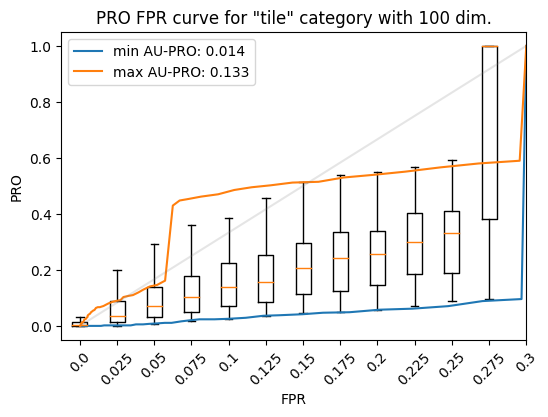

100%|██████████| 116/116 [00:05<00:00, 19.45it/s]


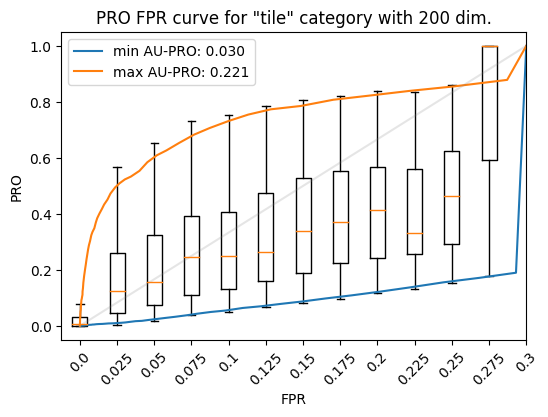

100%|██████████| 116/116 [00:20<00:00,  5.63it/s]


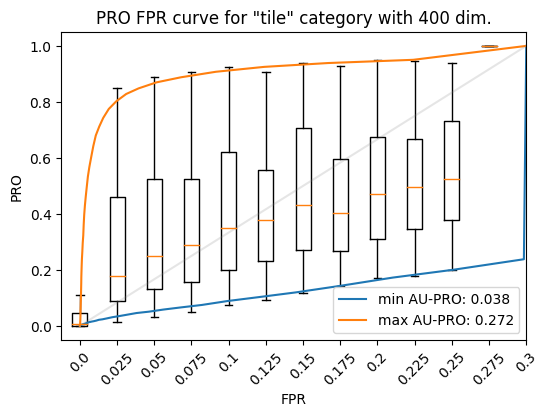

100%|██████████| 80/80 [00:01<00:00, 55.07it/s]


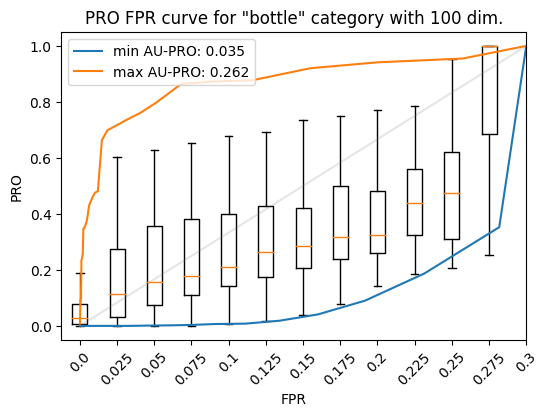

100%|██████████| 80/80 [00:03<00:00, 22.51it/s]


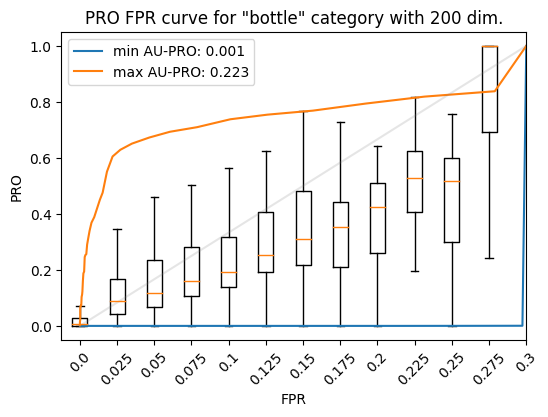

100%|██████████| 80/80 [00:10<00:00,  7.38it/s]


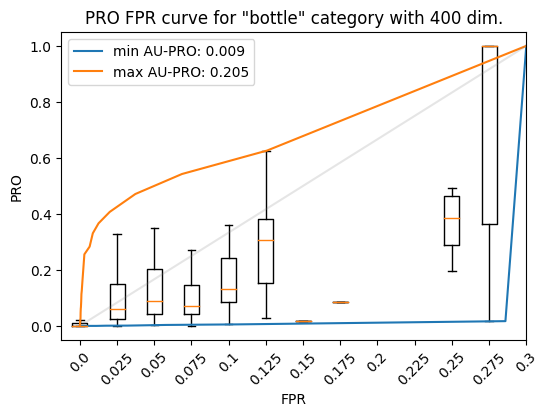

100%|██████████| 148/148 [00:01<00:00, 77.64it/s] 


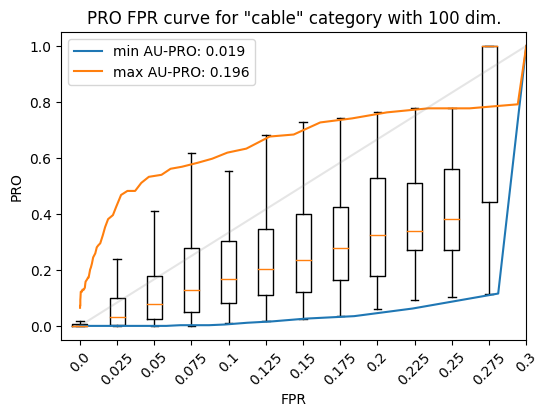

100%|██████████| 148/148 [00:06<00:00, 22.90it/s]


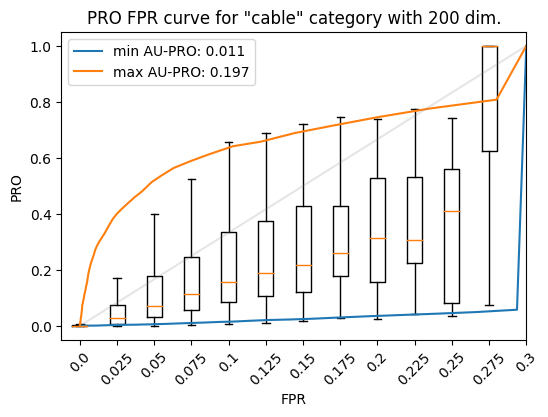

100%|██████████| 148/148 [00:26<00:00,  5.49it/s]


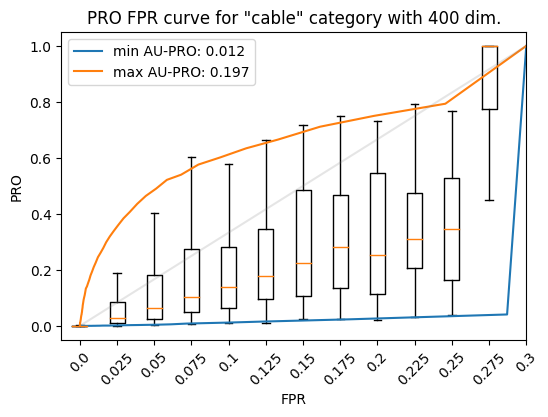

100%|██████████| 128/128 [00:01<00:00, 74.89it/s]


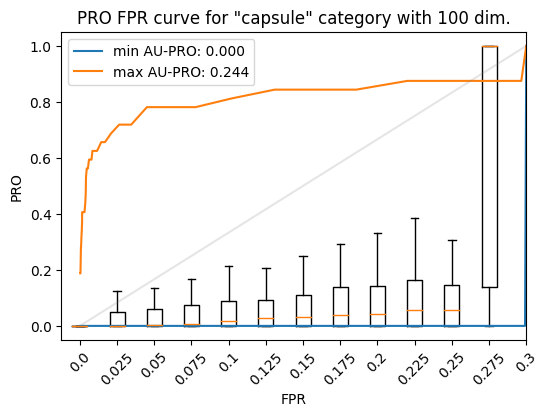

100%|██████████| 128/128 [00:05<00:00, 21.37it/s]


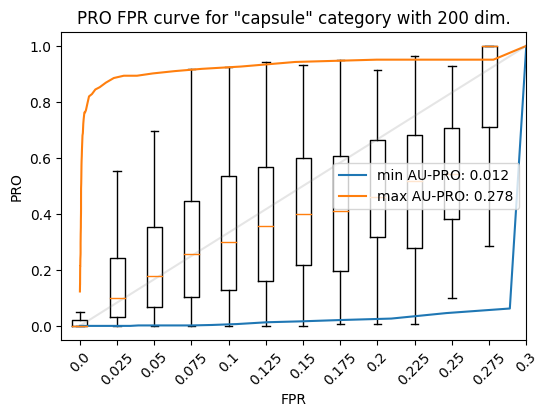

100%|██████████| 128/128 [00:20<00:00,  6.17it/s]


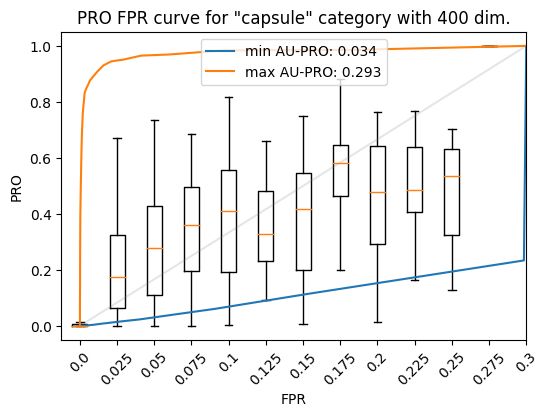

 53%|█████▎    | 16/30 [00:04<00:03,  3.69it/s]

In [45]:
all_cats, all_dims, all_aurocs, all_thr, all_ths_reults = [], [], [], [], []

for category in all_categories:
    for resize_dim in all_resize_dim:
        all_results = run_all(category, resize_dim)
        all_cats.append(category)
        all_dims.append(resize_dim)
        all_aurocs.append(all_results['auroc'])
        all_thr.append(all_results['optimal_threshold'])
        all_ths_reults.append(all_results['threshold_based_metrics'])
        

In [40]:
df_autoencoder_results = pd.DataFrame()
df_autoencoder_results['category'] = all_cats
df_autoencoder_results['resize_dim'] = all_dims
df_autoencoder_results['AUROC'] = all_aurocs
df_autoencoder_results['optimal_threshold'] = all_thr
df_autoencoder_results['threshold_results'] = all_ths_reults

In [43]:
filename = '../results/autoencoder_pro_fpr/values_all'
#df_autoencoder_results.to_csv(f'{filename}.csv', index=False)
df_autoencoder_results.to_pickle(f"{filename}.pkl")  

In [41]:
df_autoencoder_results['AUROC'][0]

,count,mean,std,min,25%,50%,75%,max
auroc,60.0,0.645706,0.114735,0.472831,0.557475,0.642311,0.717815,0.957073


In [36]:
df_autoencoder_results['threshold_results'][0]

,fpr,prc,iou,pro
count,80.000000,80.000000,80.000000,80.000000
mean,0.151386,0.103863,0.071850,0.247937
std,0.040782,0.097238,0.062300,0.212790
min,0.035224,0.000000,0.000000,0.000000
25%,0.132839,0.010929,0.009836,0.066336
50%,0.162626,0.096244,0.067104,0.220994
75%,0.178231,0.162911,0.110802,0.361704
max,0.234857,0.484583,0.292505,0.877597
